In [24]:
using Pkg
Pkg.activate("..") ## because we have environment files in the parent directory
Pkg.instantiate() ## to download all missing packages

  Activating project at `c:\Users\piotr\Dropbox\WNE\QuantEcon_all\QEcon2023\Code`


In [25]:
# load some packages we will need today
using Distributions, QuantEcon, IterTools, Plots, Optim, Interpolations, LinearAlgebra, Inequality, Statistics, ColorSchemes,PrettyTables

In [26]:

function create_ha_block(; 
    ρ_z=0.96, # log of productivity persistence
    ν_z=sqrt(0.025), # log of productivity volatility
    γ = 2, # curvature parameter of utility function
    u = γ == 1 ? x -> log(x) : x -> (x^(1 - γ) - 1) / (1 - γ), # utility function
    ϕ = 0.0, # borrowing constraint
    β= 0.98, # discount factor
    N_z= 9, # grid size for Tauchen
    mc_z = tauchen(N_z, ρ_z, ν_z, 0),
    λ_z = stationary_distributions(mc_z)[1],
    P_z = mc_z.p, # transition matrix
    z_vec = exp.(mc_z.state_values) / sum(exp.(mc_z.state_values) .* λ_z)) # normalize so that mean is 1
    return (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z)
    end

create_ha_block (generic function with 1 method)

In [28]:
function create_grid(ha_block;N_a=70,a_max=40);
    a_min = -ha_block.ϕ

    a_vec= collect(range(a_min, a_max, length=N_a))
    return (; a_vec, N_a, a_min, a_max)
end

create_grid (generic function with 1 method)

In [29]:

function getW!(W,V,a_vec,z_vec,P)
    for (i, a′) in enumerate(a_vec)
        for (j, z) in enumerate(z_vec)
            W[i,j] = sum(P[j,j′] .* V[i,j′] for j′ in eachindex(z_vec))
        end
    end
return W
end

function vfi(model,prices,grid;tol = 1e-6, maxiter = 2000)
    (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
    (; a_vec, N_a, a_min, a_max) = grid
    (; r, w) = prices
    
    V = zeros(N_a,N_z) # initialize value function
    W = similar(V) # initialize W
    σ_a′ = similar(V) # initialize policy function
    σ_c = similar(V) # initialize policy function
    
    # get W
    getW!(W,V,a_vec,z_vec,P_z)
    error = 1 + tol
    iter = 1;
    while error > tol && iter < maxiter
        V_new, (σ_a′,σ_c) = T_operator(W, model,prices, grid)
        error = maximum(abs.(V_new .- V))
        getW!(W,V_new,a_vec,z_vec,P_z)
        V = V_new
        
        iter += 1
    end
    policies = (a′ = σ_a′, c= σ_c)

    return V, policies, error, iter
end


function T_operator(W, model, prices, grid; tol = 1e-10)
    
    (; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
    (; a_vec, N_a, a_min, a_max) = grid
    (; r, w) = prices
    W_hat = linear_interpolation((a_vec,z_vec),W,extrapolation_bc=Linear()) # linear interpolation of W

    TW = similar(W)
    σ_a′ = similar(W)
    σ_c = similar(W)
    for (i, a) in enumerate(a_vec)
        for (j, z) in enumerate(z_vec)
            # solve maximization for each point in (a,z), using a itself as initial condition.

            results = optimize(a′ -> -u( (1+r)*a-a′+w*z) -
                                    β * W_hat(a′,z), a_min, (1+r)*a+w*z,GoldenSection(),g_tol=1e-8)
            TW[i,j] = -Optim.minimum(results)
            σ_a′[i,j] = Optim.minimizer(results)
            σ_c[i,j] = (1+r)*a + w*z - σ_a′[i,j]
        end
    end
    policies = (a′ = σ_a′, c= σ_c)
    return TW, policies 
end

T_operator (generic function with 1 method)

We solve for a stationary distribution for given prices

In [31]:
prices = (r = 0.005, w = 1.0)

ha_block = create_ha_block()
grid_a = create_grid(ha_block,a_max=100,N_a = 120)

V, policies, error, iter = vfi(ha_block,prices,grid_a)
error

9.945183165882554e-7

In [32]:

lines_scheme = [get(ColorSchemes.thermal,LinRange(0.0,1.0,ha_block.N_z));]



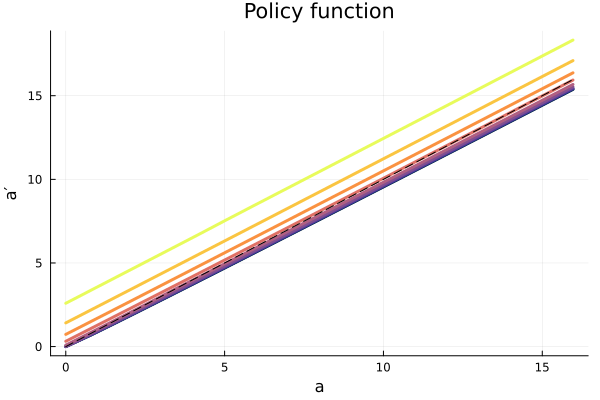

In [33]:
policy_plot = plot(xlabel = "a", ylabel = "a′", title = "Policy function")

for j in 1:ha_block.N_z
    plot!(grid_a.a_vec[1:20], policies.a′[1:20,j], label = false, color = lines_scheme[j], lw=3)
end

plot!(grid_a.a_vec[1:20], grid_a.a_vec[1:20], label = false, linestyle = :dash, color = :black)


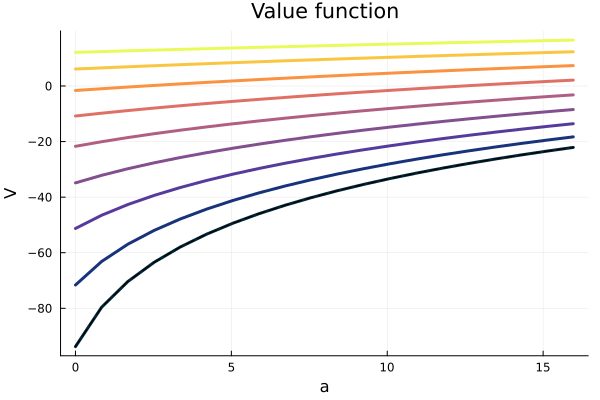

In [34]:
value_plot = plot(xlabel = "a", ylabel = "V", title = "Value function")

for j in 1:ha_block.N_z
    plot!(grid_a.a_vec[1:20], V[1:20,j], label = false, color = lines_scheme[j], lw=3)
end

plot!(grid_a.a_vec[1:20],V[1:20], label = false, linestyle = :dash, color = :black)

In [35]:

# function from https://discourse.julialang.org/t/findnearest-function/4143/4
function closest_index(a::Vector,x::Real)

    if isempty(a) == true
      error("xGrid is empty in function closest_index.")
    end

    if isnan(x) == true
      error("val is NaN in function closest_index.")
    end

   idx = searchsortedfirst(a,x)
   if (idx==1); return idx; end
   if (idx>length(a)); return length(a); end
   if (a[idx]==x); return idx; end
   if (abs(a[idx]-x) < abs(a[idx-1]-x))
      return idx
   else
      return idx-1
   end
end

function closest_value_and_index(xGrid::Vector, val::Real)

   # get index
   ibest = closest_index(xGrid, val)

   # Return best value on grid, and the corresponding index
   return xGrid[ibest], ibest

end

closest_value_and_index (generic function with 1 method)

In [38]:

function get_q(w_grid,w) # code from https://julienpascal.github.io/post/young_2010/


w_min = minimum(w_grid)
w_max = maximum(w_grid)
nW = length(w_grid)

q = zeros(length(w_grid),length(w_grid))


    for (wIndexTrue, w_temp) in enumerate(w_grid)


        # Project true value on the grid:
        (wValue_proj, wIndex_proj) = closest_value_and_index(w_grid, w[wIndexTrue])

        # To store the location of the value below and above the true value:
        wIndex_below = 0
        wIndex_above = 0

        # If the true value is above the projection
        if w[wIndexTrue] >= wValue_proj
            wIndex_below = wIndex_proj
            wIndex_above = wIndex_proj + 1
        # If the true value is below the projection
        elseif w[wIndexTrue] < wValue_proj
            wIndex_below = wIndex_proj -1
            wIndex_above = wIndex_proj
        end

        # Boundary cases
        if wIndex_proj == 1
            wIndex_below = 1
            wIndex_above = 2
        elseif wIndex_proj == nW
            wIndex_below = nW - 1
            wIndex_above = nW
        end

        # Special case 1: w < w_min
        if w[wIndexTrue] <= w_min
            p = 1
        elseif w[wIndexTrue] >= w_max
        # Special case 2: w > w_max
            p = 0
        else
            p = 1.0 - ((w[wIndexTrue] - w_grid[wIndex_below])/(w_grid[wIndex_above] - w_grid[wIndex_below]))
            p = min(1.0, max(0.0, p))
        end



    q[wIndexTrue, wIndex_below] = p
    q[wIndexTrue, wIndex_above] = 1.0 - p
end

    return q
end

get_q (generic function with 1 method)

In [39]:

function get_transition(model, policies, grid)
    
(; ρ_z, ν_z, γ,  u, ϕ, β, N_z, mc_z, z_vec, P_z , λ_z) = model
(; a_vec, N_a, a_min, a_max) = grid

Q = zeros(N_a * N_z,N_a * N_z)


for (j, z) in enumerate(z_vec)
        for (j′, z′) in enumerate(z_vec)
                Q[(j-1)*N_a+1:j*N_a,(j′-1)*N_a+1:j′*N_a] = get_q(a_vec,policies.a′[:,j]) .* P_z[j,j′]
        end
end


return Q
end

get_transition (generic function with 1 method)

In [43]:
function stationary_distribution_hh(model, policies, grid)

    Q = get_transition(model, policies, grid)

    N_a = grid.N_a
    N_z = model.N_z    
    z_vec = model.z_vec

    λ_vector = (Q^10000)[1,:]
    λ = zeros(N_a, N_z)

    for (j, z) in enumerate(z_vec)
        for (j, z′) in enumerate(z_vec)
            λ[:,j] = λ_vector[(j-1)*N_a+1:j*N_a]
        end
    end

    λ_a = sum(λ,dims=2)
    λ_z = sum(λ,dims=1)'
    return λ, λ_vector, λ_a, λ_z
end

stationary_distribution_hh (generic function with 1 method)

In [44]:
λ, λ_vector, λ_a, λ_z = stationary_distribution_hh(ha_block, policies, grid_a)



([0.00612935222270524 0.01941421918175969 … 1.1732583795882711e-6 2.1964866739668527e-10; 0.001390387350235926 0.005378674466356268 … 1.292271917630003e-5 2.0240474997411865e-8; … ; 3.1364399686050394e-28 3.350651448940745e-21 … 1.7573668982992547e-5 9.185096655637308e-6; 3.641100674793034e-53 9.53423407112036e-38 … 0.00013934916519220416 0.00011763099051403], [0.00612935222270524, 0.001390387350235926, 0.0008589153350950971, 0.0006091947390465387, 0.00046202525951885164, 0.0003647518045520495, 0.00029574921101242063, 0.0002444337375912552, 0.0002049987171942594, 0.00017393820842334214  …  1.4820385971313042e-5, 1.3945131019373052e-5, 1.312189356610343e-5, 1.2342192070748944e-5, 1.1613455746772332e-5, 1.0929342875132378e-5, 1.0297802548863647e-5, 9.713255222489935e-6, 9.185096655637308e-6, 0.00011763099051403], [0.1208525826928306; 0.06833245504650545; … ; 5.637795744612548e-5; 0.00028648411413813215;;], [0.01206137813115985; 0.04514702636157517; … ; 0.04514702636157533; 0.012061378131

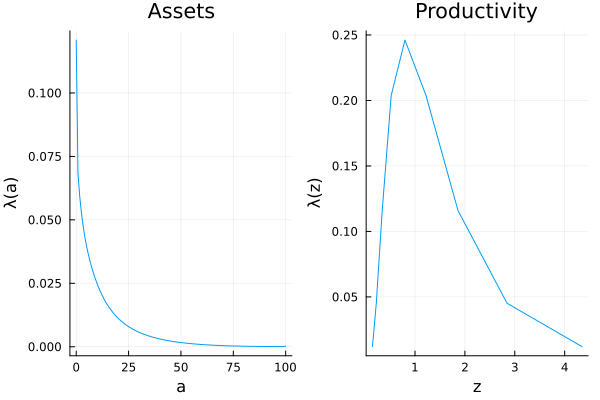

In [42]:
p1 = plot(grid_a.a_vec, λ_a, xlabel = "a", ylabel = "λ(a)",title = "Assets", legend = false)
p2 = plot(ha_block.z_vec, λ_z, xlabel = "z", ylabel = "λ(z)", title = "Productivity",  legend = false)
plot(p1,p2)


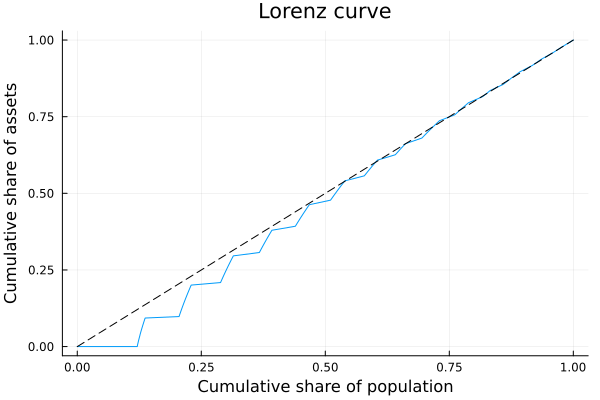

In [45]:
lorenz_a_pop,lorenz_a_share=lorenz_curve(grid_a.a_vec,vec(λ_a))
plot(lorenz_a_pop,lorenz_a_share,xlabel="Cumulative share of population",ylabel="Cumulative share of assets",title="Lorenz curve",legend=false)
plot!(lorenz_a_pop,lorenz_a_pop,linestyle=:dash,color=:black)

In [46]:
function show_statistics_hugget(ha_block,grid,λ_a,λ_z)
# warning - this can be misleading if we allow for negative values!
lorenz_a_pop,lorenz_a_share=lorenz_curve(grid.a_vec,vec(λ_a))
lorenz_z_pop,lorenz_z_share=lorenz_curve(ha_block.z_vec,vec(λ_z))



lorenz_a = LinearInterpolation(lorenz_a_pop, lorenz_a_share);
lorenz_z = LinearInterpolation(lorenz_z_pop, lorenz_z_share);


header = (["", "Assets", "Income"])

data = [           
                     "Bottom 50% share"         lorenz_a(0.5)        lorenz_z(0.5)    ;
                     "Top 10% share"            1-lorenz_a(0.9)         1-lorenz_z(0.9)     ;
                     "Top 1% share"             1-lorenz_a(0.99)        1-lorenz_z(0.99)    ;  
                     "Gini Coefficient"      wgini(grid.a_vec,vec(max.(0,λ_a)))      wgini(ha_block.z_vec,vec(max.(0.0,λ_z)))    ;]

return pretty_table(data;header=header,formatters=ft_printf("%5.3f",2:3))
end
    


show_statistics_hugget (generic function with 1 method)

In [48]:
show_statistics_hugget(ha_block,grid_a,λ_a,λ_z)

┌──────────────────┬────────┬────────┐
│                  │ Assets │ Income │
├──────────────────┼────────┼────────┤
│ Bottom 50% share │  0.474 │  0.392 │
│    Top 10% share │  0.097 │  0.122 │
│     Top 1% share │  0.010 │  0.012 │
│ Gini Coefficient │  0.574 │  0.360 │
└──────────────────┴────────┴────────┘


In [49]:
function solve_hh_block(grid,model,prices)
    V, policies, error, iter = vfi(model,prices,grid)
    λ, λ_vector, λ_a, λ_z = stationary_distribution_hh(model, policies, grid)
    A′ = sum(λ .* policies.a′)
    C  = sum(λ .* policies.c)


    return V, policies, error, iter, λ, λ_vector, λ_a, λ_z, A′, C
end


solve_hh_block (generic function with 1 method)

In [50]:
V, policies, error, iter, λ, λ_vector, λ_a,λ_z, A′, C = solve_hh_block(grid_a,ha_block,prices)

display("VFI error = $error in $iter iterations")
display("A′ = $A′")
display("C = $C")

"VFI error = 9.945183165882554e-7 in 638 iterations"

"A′ = 12.09410719820606"

"C = 1.0602494834256762"